In [1]:
# first spin up the WebDP server
# i.e 'docker-compose up -d'

import webdp_demo as dem
import requests
import math

BASE                     = "http://localhost:8000/v2"
URL_LOGIN                = BASE + "/login"
URL_DATASETS             = BASE + "/datasets"
URL_USERS                = f"{BASE}/users"
URL_DATASETS_ID          = lambda did: f"{BASE}/datasets/{did}"
URL_DATASETS_UPLOAD      = lambda did: f"{BASE}/datasets/{did}/upload"
URL_USER_DATASET_BUDGET  = lambda user, dataset: f"{BASE}/budgets/allocations/{user}/{dataset}"
URL_USER_BUDGETS         = lambda user: f"{BASE}/budgets/users/{user}"
URL_DATASET_BUDGETS      = lambda dataset: f"{BASE}/datasets/{dataset}"
URL_EVALUATE_F           = lambda engine: f"{BASE}/queries/evaluate?engine={engine}"
URL_EVALUATE             = f"{BASE}/queries/evaluate"
URL_ACCURACY_F           = lambda engine: f"{BASE}/queries/accuracy?engine={engine}"
URL_VALIDATE             = f"{BASE}/queries/validate"
URL_FEATURES             = f"{BASE}/queries/features"

dataset = dem.gen_csv(10000) # generate 10 000 rows of data

print("We will be working with the dataset:")
for c in dem.column_schema:
    print(c)



We will be working with the dataset:
{'name': 'zip_code', 'type': {'name': 'Text'}}
{'name': 'salary_SEK', 'type': {'name': 'Int', 'low': 10000, 'high': 100000}}
{'name': 'job_sector', 'type': {'name': 'Enum', 'labels': ['Finance', 'IT', 'Education', 'Unemployed', 'Other']}}
{'name': 'has_criminal_record', 'type': {'name': 'Bool'}}
{'name': 'distance_to_closest_neighbor_km', 'type': {'name': 'Double', 'low': 0, 'high': 100}}


In [2]:
# user creation

root_token = requests.post(url=URL_LOGIN, json={"username":"root", "password":"123"}).json()["token"]

auth = lambda token: {"Authorization" : "Bearer " + token}

analyst = {
    "handle" : "james",
    "name" : "James Bond",
    "password" : "jamesbond007",
    "roles" : ["Analyst"]
}

curator = {
    "handle" : "m",
    "name" : "M",
    "password" : "godsavethequeen",
    "roles" : ["Curator"]
}

requests.post(url=URL_USERS, json=analyst, headers=auth(root_token))
requests.post(url=URL_USERS, json=curator, headers=auth(root_token))

analyst_token = requests.post(url=URL_LOGIN, json={"username" : "james", "password" : "jamesbond007"}).json()["token"]
curator_token = requests.post(url=URL_LOGIN, json={"username" : "m", "password" : "godsavethequeen"}).json()["token"]

print("An analyst and a curator have logged in")



An analyst and a curator have logged in


In [3]:
# Let the curator create and upload the data

response = requests.post(
    url=URL_DATASETS, 
    json= {
        "name" : "test_dataset",
        "privacy_notion" : "PureDP",
        "owner" : "m",
        "total_budget" : {
            "epsilon" : 1.0
        },
        "schema" : dem.column_schema
    },
    headers=auth(curator_token)
)

dataset_id = response.json()["id"]

head = auth(curator_token)
head["Content-Type"] = "text/csv"

_ = requests.post(
    url=URL_DATASETS_UPLOAD(dataset_id), data=dataset, headers=head
)

In [4]:
# now, budget has to be allocated to an analyst before they can make a query

query_build = lambda q: {
    "dataset" : 1,
    "budget"  : {"epsilon" : 0.05},
    "query"   : q
}
query = [
    {
        "filter" : ["job_sector == \"Finance\""]
    },
    {
        "count" : {
            "column" : "job_sector",
            "mech" : "Laplace"
        }
    }

]


q_req = lambda engine, q : requests.post(
    url=URL_EVALUATE_F(engine), 
    json=q,
    headers=auth(analyst_token)
)

response = q_req("opendp", query_build(query))

print(f"Result of query to WebDP: {response.text}")


Result of query to WebDP: {"detail":"bad request: not have budget for making the query","status":400,"title":"Bad Request","type":"Bad Request"}



In [5]:
# lets give them some budget

_ = requests.post(
    url=URL_USER_DATASET_BUDGET("james", 1), json={"epsilon" : 0.5}, headers=auth(curator_token)
)

# and now lets try the query
response = q_req("opendp", query_build(query))

number_in_finance = response.json().get("rows")[0].get("job_sector")

print(f"Number of people working in finance: {number_in_finance}")

Number of people working in finance: 983


In [6]:
# lets see what the mean salary of those working in finance is

query2 = [
    {
        "filter" : ["job_sector == \"Finance\""]
    },
    {
        "sum" : {
            "column" : "salary_SEK",
            "mech" : "Laplace"
        }
    }
]

response2 = q_req("opendp", query_build(query2))


sum_total_salary = int(response2.json().get("rows")[0].get("salary_SEK"))

print(f"Total salary of all in Finance: {sum_total_salary}")

Total salary of all in Finance: 64051303


In [7]:
mean_salary_finance = sum_total_salary // number_in_finance

print(f"The mean salary of all in finance is: {mean_salary_finance}")



The mean salary of all in finance is: 65159


In [8]:
# lets get an estimate of how accurate the mean value is

confidence = math.sqrt(0.95)

acc_q = lambda engine, q: requests.post(
    url=URL_ACCURACY_F(engine=engine),
    json=q,
    headers=auth(analyst_token)
)

query_a  = query_build(query)
query_a["confidence"] = confidence

query2_a = query_build(query2)
query2_a["confidence"] = confidence

count_acc = acc_q("opendp", query_a)
sum_acc   = acc_q("opendp", query2_a)

count_acc_res = float(count_acc.json()[0])
sum_acc_res   = float(sum_acc.json()[0])

print(f"Accuracy of count {count_acc_res} at {confidence} level of confidence")
print(f"Accuracy of sum {sum_acc_res} at {confidence} level of confidence")


Accuracy of count 74.01651759249056 at 0.9746794344808963 level of confidence
Accuracy of sum 7352277.194155676 at 0.9746794344808963 level of confidence


If $S$ is the true sum and $C$ the true count, let $\tilde{S}$ be the DP sum and $\tilde{C}$ the DP count. 
Let also $a_x$ denote the accuracy of the measurement of $x$, where the DP measurement $\tilde{x}$ is at most $a_x$ away from the true value $x$ at some level of confidence $Con_x$. Then:
$$
    \frac{\tilde{S}-a_S}{\tilde{C}+a_C} \leq \frac{S}{C} \leq \frac{\tilde{S} + a_S}{\tilde{C} - a_C}

$$
Is true at a confidence of $Con_S \cdot Con_C$ for $0 < \tilde{C}-a_C$

## Proof:

We know that $\tilde{S} \leq S + a_S$, so $\tilde{S}-a_S \leq S$. By the same token: $C \leq \tilde{C} + a_C$ Then we have that:
$$
    \frac{\tilde{S} - a_S}{\tilde{C} + a_C} \leq \frac{S}{\tilde{C} + a_C} \leq \frac{S}{C}

$$
Thus, $\frac{\tilde{S} - a_S}{\tilde{C} + a_C}$ is a lower bound of the true mean. By the same reasoning as above we have that:

$$
    \frac{\tilde{S} + a_S}{\tilde{C} - a_C} \geq \frac{S}{\tilde{C} - a_C} \geq \frac{S}{C}
$$
So $\frac{\tilde{S} + a_S}{\tilde{C} - a_C}$ is an upper bound of the true mean. Since the accuracies $a_C$ and $a_S$ are independent of each other, we can be $Con_C \cdot Con_S$ certain that both are true at the same time, which finalizes the proof. 

In [10]:

min_bound = (sum_total_salary - sum_acc_res) / (number_in_finance + count_acc_res)
max_bound = (sum_total_salary + sum_acc_res) / (number_in_finance - count_acc_res)

print(f"The true mean is in the inteval [{min_bound}, {max_bound}] at a confidence of {confidence * confidence}")

The true mean is in the inteval [53640.62421180005, 78553.22079674985] at a confidence of 0.9499999999999998


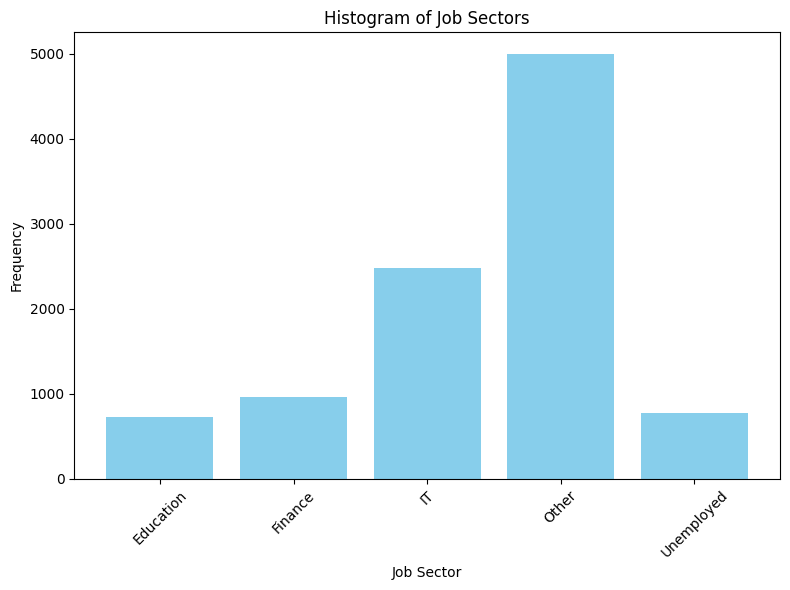

In [11]:
# we could also plot the distribution of people accross different job sectors

import matplotlib.pyplot as plt

hist = [
    {
        "bin" : {
            "job_sector" : ["Finance", "Education", "Other", "Unemployed", "IT"]
        }
    },
    {
        "count" : {
            "column" : "job_sector",
            "mech" : "Laplace"
        }
    }
]

hist_res = q_req("opendp", query_build(hist)).json().get("rows")[0]

labels = list(hist_res['job_sector'].keys())
values = list(hist_res['job_sector'].values())

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Job Sector')
plt.ylabel('Frequency')
plt.title('Histogram of Job Sectors')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()



Now, the user is not restricted to use only the OpenDP connector. We can call `queries/features` to see which connectors are available and what their features are.

In [12]:


features = requests.get(
    url=URL_FEATURES, headers=auth(analyst_token)
)

print("Connectors: ")
for connector in features.json():
    print(connector)


Connectors: 
googledp
opendp
tumult


Let's use googledp

In [13]:

googledp_features = features.json().get("tumult")
print("Tumult features:")
for feature in googledp_features:
    print(f"{feature}: {googledp_features.get(feature)}")

Tumult features:
bin: {'enabled': True, 'required_fields': {'column': ' Name of the column used to assign bins.', 'name': 'The name of the column that will be created. If None (the default), the input column name with _binned appended to it.', 'spec': 'A BinningSpec that defines the binning operation to be performed.'}}
count: {'enabled': True, 'required_fields': {'mechanism': ' Choice of noise mechanism. By default, the framework automatically selects an appropriate mechanism.', 'name': '(Optional[str]) – Name for the resulting aggregation column. Defaults to “count”.'}}
filter: {'enabled': True, 'required_fields': {'array': 'an array of strings of SQL expressions specifying the filter to apply to the data. For example, the string “A > B” matches rows where column A is greater than column B'}}
groupby: {'enabled': True, 'required_fields': {'key': ' A KeySet giving the set of groupby keys to be used when performing an aggregation.'}}
map: {'enabled': True, 'required_fields': {'augment'

It looks like we can make a histogram in Tumult as well

In [14]:
hist_2_res = q_req("tumult", query_build(hist)).json()

print(hist_2_res)

{'detail': 'something bad happened: {"title":"Bad request","type":"","status":400,"detail":"Invalid query: Unsupported Spark data type: Tumult Analytics does not yet support the Spark data types for the following columns: [(\'has_criminal_record\', BooleanType())]. Consider casting these columns into one of the supported Spark data types: {DateType(), IntegerType(), DoubleType(), LongType(), StringType(), FloatType(), TimestampType()}."}', 'status': 500, 'title': 'Unexpected error', 'type': 'Unexpected error'}


Oops! I guess not? 